# Creating an Efficient Portfolio

With this project, I wanted to see if I could take 5 random stocks, and then create an efficient portfolio, maximizing the returns based off an investors risk appetite.

Some of the things I wanted to do in this project were:
- Get a constantly updated list of the stocks inside the S&P500
    - [Updated S&P500](#Get-Updated-S&P500)
- Get 5 random stocks from the S&P500
    - [Get Stocks](#Pick-5-Random-Stocks)
- Visually see some of the statistical analysis
    - [Visual Representation](#Visual-Representation)
- Run some statistical analysis on those stocks
    - [Statistical Analysis](#Statistical-Analysis)
- Model an efficient frontier and output an efficient portfolio
    - [Efficient Portfolio](#Mean-Variance-Optimization)
- Take a users inputs, and output the optimal portfolio under his constraints.
    - [User Input Portfolio](#User-Input-Portfolio)


Though there are other API's I've used in the past (specifically IEX which has more detailed information), I opted to go with the Yahoo api since it's free and gives us the basic information necessary to run some analysis.

***

## Import modules

Import the modules we'll be using throughout our project

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import math
import requests
from datetime import datetime
import cvxopt as opt
from cvxopt import blas, solvers
import random

now = datetime.now()

***

## Building the Portfolio

In this section will:
- Get updated S&P500 list
- Pick 5 random stocks
- Run statistical analysis on those 5 stocks

### Get Updated S&P500

In [2]:
#stocks in sp500 always changing, so run this code to get updated sp500 list:

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]

symbols = sorted(df.Symbol)

df

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


### Pick 5 Random Stocks

In [3]:
#pick 5 random stocks from sp500 to run some analysis:

#random_stocks = random.sample(symbols, 5)
random_stocks = ['BLL', 'WDC', 'IVZ', 'PPL', 'TWTR']

In [4]:
#since I dont know anything about those stocks, get some info on them: 

stock_information = pd.DataFrame(columns = df.columns)

for i in random_stocks:
    stock_information = stock_information.append(df[df.Symbol == i], ignore_index = True)

stock_information

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,BLL,Ball Corp,reports,Materials,Metal & Glass Containers,"Broomfield, Colorado",1984-10-31,9389,1880
1,WDC,Western Digital,reports,Information Technology,"Technology Hardware, Storage & Peripherals","San Jose, California",2009-07-01,106040,1970
2,IVZ,Invesco Ltd.,reports,Financials,Asset Management & Custody Banks,"Atlanta, Georgia",2008-08-21,914208,1935
3,PPL,PPL Corp.,reports,Utilities,Electric Utilities,"Allentown, Pennsylvania",NaN,922224,1920
4,TWTR,"Twitter, Inc.",reports,Communication Services,Interactive Media & Services,"San Francisco, California",2018-06-07,1418091,2006


#### Quick Glance

Of these 5 random stocks, I have heard of `TWTR` (Twitter - social media) and `WDC` (Western Digital - since I bought a hard drive from them on Black Friday). Other than those 2, I have no prior knowledge of `BLL`, `IVZ`, or `PPL`. Looking at their GICS information, it seems like there shouldnt be any correlation between these stocks. The companies range from social media, to asset management, to metal and glass containers, so I don't think there should be much correlation between these stocks. It's possible that there is some correlation between them, but as of now I'm not seeing it just based off their sectors and quick information.

**Note** - I'm looking to see information PRE-pandemic...the pre- and post- pandemic analysis are completely different as they are completely different trading environments

In [5]:
#now want to see if i can pull those random symbols from yahoo api using datareader
#starting from 2017 to 2019 (pre-pandemic 2019)

start = datetime(2017, 1, 1)
end = datetime(2019, 1, 2)

stocks = web.DataReader(random_stocks, start=start, end=end, data_source = 'yahoo')

stocks.head()

Attributes  Adj Close                                                  Close  \
Symbols           BLL        WDC        IVZ        PPL       TWTR        BLL   
Date                                                                           
2017-01-03  36.510979  62.206829  24.925303  27.635124  16.440001  37.875000   
2017-01-04  37.065277  63.201378  25.602228  27.691963  16.860001  38.450001   
2017-01-05  37.045986  63.210342  25.400763  27.854383  17.090000  38.430000   
2017-01-06  37.209869  63.058014  25.408823  28.065523  17.170000  38.599998   
2017-01-09  36.621845  64.384033  24.860834  27.789417  17.500000  37.990002   

Attributes                                              ...       Open  \
Symbols           WDC        IVZ        PPL       TWTR  ...        BLL   
Date                                                    ...              
2017-01-03  69.430000  30.930000  34.029999  16.440001  ...  37.855000   
2017-01-04  70.540001  31.770000  34.099998  16.860001  ...  37.904999   
2017-01-05  70.550003  31.520000  34.299999  17.090000  ...  38.349998   
2017-01-06  70.379997  31.530001  34.560001  17.170000  ...  38.465000   
2017-01-09  71.860001  30.850000  34.220001  17.500000  ...  38.535000   

Attributes                                                 Volume             \
Symbols           WDC        IVZ        PPL       TWTR        BLL        WDC   
Date                                                                           
2017-01-03  68.949997  30.980000  34.049999  16.309999  1830600.0  4479000.0   
2017-01-04  69.580002  31.040001  34.049999  16.500000  2219800.0  3653200.0   
2017-01-05  71.059998  31.559999  34.169998  16.910000  1965800.0  3638300.0   
2017-01-06  70.480003  31.600000  34.169998  17.240000  1001800.0  3274300.0   
2017-01-09  70.900002  31.250000  34.540001  17.219999  1329800.0  3909600.0   

Attributes                                    
Symbols           IVZ        PPL        TWTR  
Date                                          
2017-01-03  3483500.0  3367000.0  11147900.0  
2017-01-04  3470400.0  3187400.0  15861300.0  
2017-01-05  2797500.0  3497000.0  17074400.0  
2017-01-06  3522500.0  3542700.0  14665100.0  
2017-01-09  3525000.0  5474700.0  11918100.0  

[5 rows x 30 columns]

- Have a dataframe now of the 5 stocks we picked with some prices. let's see exactly what were looking at:

In [6]:
stocks.columns

MultiIndex([('Adj Close',  'BLL'),
            ('Adj Close',  'WDC'),
            ('Adj Close',  'IVZ'),
            ('Adj Close',  'PPL'),
            ('Adj Close', 'TWTR'),
            (    'Close',  'BLL'),
            (    'Close',  'WDC'),
            (    'Close',  'IVZ'),
            (    'Close',  'PPL'),
            (    'Close', 'TWTR'),
            (     'High',  'BLL'),
            (     'High',  'WDC'),
            (     'High',  'IVZ'),
            (     'High',  'PPL'),
            (     'High', 'TWTR'),
            (      'Low',  'BLL'),
            (      'Low',  'WDC'),
            (      'Low',  'IVZ'),
            (      'Low',  'PPL'),
            (      'Low', 'TWTR'),
            (     'Open',  'BLL'),
            (     'Open',  'WDC'),
            (     'Open',  'IVZ'),
            (     'Open',  'PPL'),
            (     'Open', 'TWTR'),
            (   'Volume',  'BLL'),
            (   'Volume',  'WDC'),
            (   'Volume',  'IVZ'),
            (   'Vol

- So we have Open, Close, High, Low, Volume, and Adj Close (this is the closing price accounting for dividends)

In [7]:
# let's look at the adjusted closing prices since thats the closing price of the stocks per day.
adj_close = stocks["Adj Close"]

adj_close.head()


Symbols,BLL,WDC,IVZ,PPL,TWTR
Date,,,,,
2017-01-03,36.510979,62.206829,24.925303,27.635124,16.440001
2017-01-04,37.065277,63.201378,25.602228,27.691963,16.860001
2017-01-05,37.045986,63.210342,25.400763,27.854383,17.090000
2017-01-06,37.209869,63.058014,25.408823,28.065523,17.170000
2017-01-09,36.621845,64.384033,24.860834,27.789417,17.500000


- Clean dataframe of day-by-day closing prices of our 5 stocks

In [8]:
# want to see a quick summary of key stats to have some understanding going forward 
adj_close.describe()

Symbols,BLL,WDC,IVZ,PPL,TWTR
count,503.000000,503.000000,503.000000,503.000000,503.000000
mean,39.325435,71.177453,25.231004,28.134408,25.332942
std,3.232766,13.130418,4.168596,3.097631,8.628170
min,34.476700,32.824841,13.717840,22.070314,14.290000
25%,36.990002,66.776264,22.806392,25.438858,17.555000
50%,38.843060,75.374367,26.125170,27.653137,24.230000
75%,40.735876,80.052589,28.397279,31.244924,32.300001
max,49.510494,97.646362,32.033100,33.360001,46.759998


- So we see some good information here about each of the stocks. Looking at `TWTR` specifically (since its the most known of the stocks):
    - the average price of `TWTR` from 2017/01 - 2019/01 was <font color=blue>25.33</font>
    - the standard deviation was <font color=blue>8.62</font> (*that is a pretty big STD for a tech stock...TWTR must've been volatile*)
    - had a pretty big high...<font color=blue>46.76</font> is almost double its starting price from 2017/01

### Visual Representation

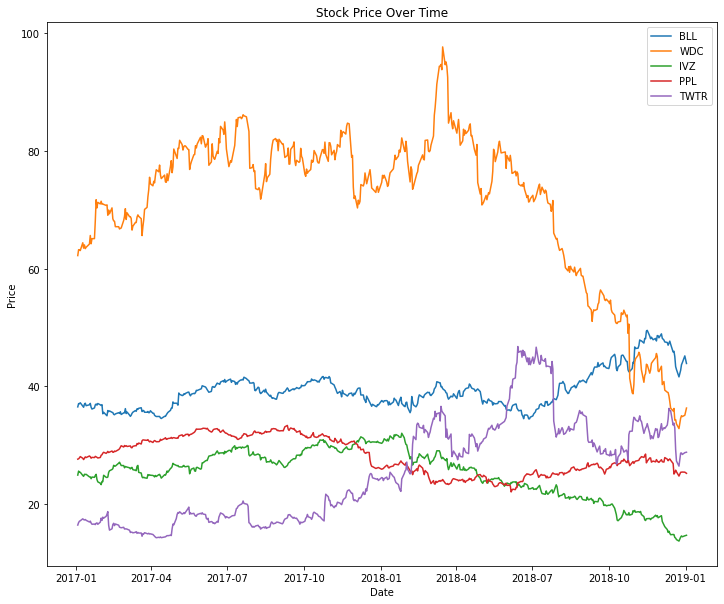

In [9]:
#sweet, got the 5 random stocks, now want to see price over time

plt.figure(figsize = (12,10))
plt.plot(adj_close)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.legend(adj_close.columns)
plt.show()

#### Quick Glance

1) *Volatility Abundant*:
- There is some serious volatility in these stocks.
    - `WDC` has a 50 buck range and has a huge sell off from January 2018 -> January 2019
    - `TWTR` meanwhile almost doubles in value from January 2017 -> July 2018.
        - There's also a HUGE drop off sometime after July...?
            - Possibly a dividend? Horrible earnings? Bad news?

2) *Correlation*:
- There doesn't seem to be any correlation between these stocks. It's possible that `BLL` and `IVZ` have a negative correlation? Seems they are moving in opposite directions, but the others seem to be quite sporadic. Visually - nothing conclusive here.

### Statistical Analysis

Let's get some statistics about each of these 5 random stocks (which we'll use to calculate our efficient portfolio):


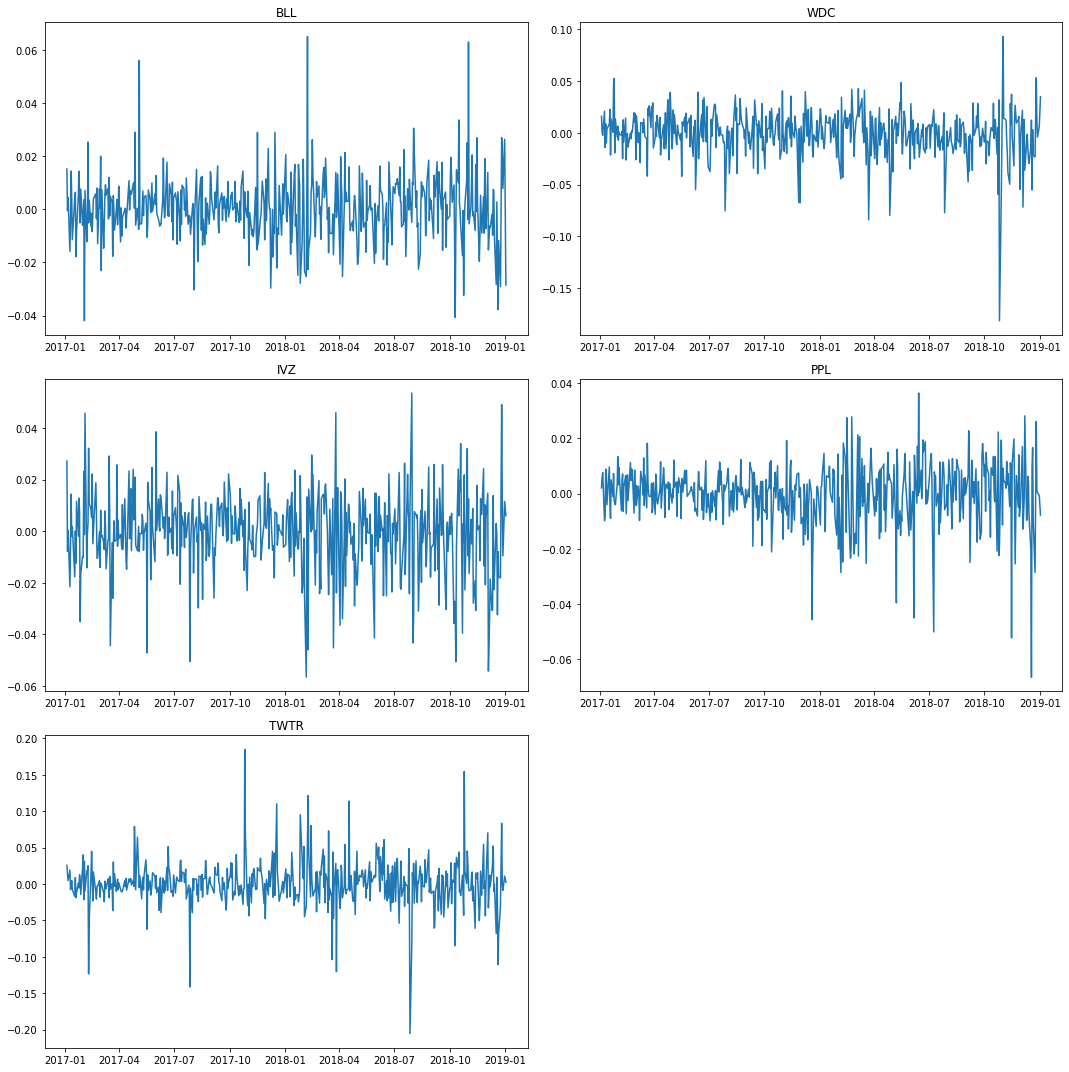

<Figure size 432x288 with 0 Axes>

In [10]:
simple_return = adj_close.pct_change()

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)

ax1.plot(simple_return['BLL'])
ax1.set_title("BLL")

ax2.plot(simple_return['WDC'])
ax2.set_title("WDC")

ax3.plot(simple_return['IVZ'])
ax3.set_title("IVZ")

ax4.plot(simple_return['PPL'])
ax4.set_title("PPL")

ax5.plot(simple_return['TWTR'])
ax5.set_title("TWTR")

plt.tight_layout()
plt.show()
plt.clf()

#### Daily Moves Analysis

- `BLL`:
    - seems pretty consistent, minus a few big up moves
- `WDC`:
    - Much more volatile than the other stocks. Moves are in the +/-0.05 range
    - Huge spike down in November 2018
    - Daily moves are consistent on the downside. Multiple days with losses >-0.5
- `IVZ`:
    - Pretty whippy but consistent 
- `PPL`:
    - Extremely uninspiring in 2017. It has no big up/down days and consitently stay in a 0.02 range
    - 2018 shows volatility - especially with a few big daily downside moves
- `TWTR`:
    - EXTREMELY volatile. Has multiple days where daily moves are >0.10
    - Has 2 days that it moves about 0.20 (November 2017 and August 2018)


- `Overall`:
    - `TWTR`, followed by `WDC`, are showing huge volatility. Daily moves are in the .05 and higher range
    - The other stocks show relatively calm moves compared to the two above
    

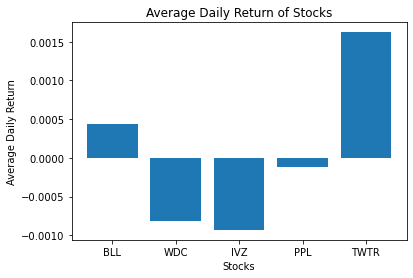

In [11]:
# see what the average daily return is on each stock

simple_returns_daily_return = simple_return.mean()

plt.bar(random_stocks, simple_returns_daily_return)
plt.xlabel("Stocks")
plt.ylabel("Average Daily Return")
plt.title("Average Daily Return of Stocks")
plt.show()

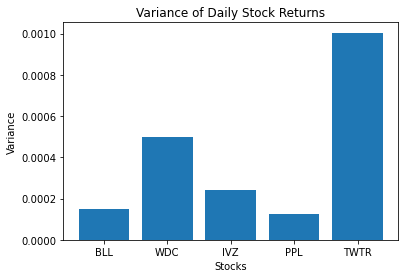

In [12]:
#see the variance of each stock 

simple_return_var = simple_return.var()

plt.bar(random_stocks, simple_return_var)
plt.xlabel("Stocks")
plt.ylabel("Variance")
plt.title("Variance of Daily Stock Returns")
plt.show()

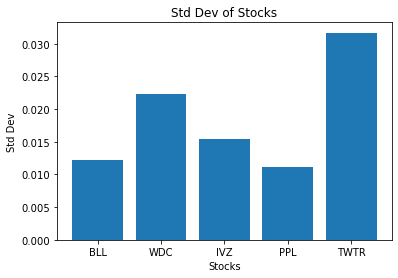

In [13]:
#see the standard deviation of each stock

simple_return_std = simple_return.std()

plt.bar(random_stocks, simple_return_std)
plt.xlabel("Stocks")
plt.ylabel("Std Dev")
plt.title("Std Dev of Stocks")
plt.show()

In [14]:
#see the correlation of the stocks

correlation = simple_return.corr()
correlation


Symbols,BLL,WDC,IVZ,PPL,TWTR
Symbols,,,,,
BLL,1.000000,0.245366,0.328791,0.189251,0.147777
WDC,0.245366,1.000000,0.325156,0.024846,0.250495
IVZ,0.328791,0.325156,1.000000,0.081179,0.131610
PPL,0.189251,0.024846,0.081179,1.000000,-0.027687
TWTR,0.147777,0.250495,0.131610,-0.027687,1.000000


In [15]:
#Minimum value in the corr matrix:
a, b = correlation.stack().idxmin()
print(a, b)

#Maximum value in the corr matrix:
c, d = correlation.where(correlation < 1.00).stack().idxmax()
print(c, d)


PPL TWTR
BLL IVZ


### Analysis

These are pretty weak correlations across the board. The most correlated stocks are `BLL` and `IVZ` with a correlation of 0.329. The least correlated stocks are `PPL` and `TWTR` with a correlation of -0.028. What we saw visually before was true, we didnt visually see much a correlation between the stocks, and the stats confirmed it. 

We also see 3 stocks produce an average *negative* daily return in a time when the market had a pretty big upswing...showing us that these 3 stocks were losers in the overall market rally.

## Mean-Variance Optimization

Can we return a set of portfolio options with volatility and annualized returns

In [16]:
# 5000 random sample portfolios to create optimal portfolio

def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [17]:
#check the covariance of the portfolio

simple_return.cov()

Symbols,BLL,WDC,IVZ,PPL,TWTR
Symbols,,,,,
BLL,0.000149,0.000067,0.000062,0.000026,0.000057
WDC,0.000067,0.000498,0.000112,0.000006,0.000177
IVZ,0.000062,0.000112,0.000239,0.000014,0.000065
PPL,0.000026,0.000006,0.000014,0.000124,-0.000010
TWTR,0.000057,0.000177,0.000065,-0.000010,0.001004


In [18]:
portfolio_options = return_portfolios(simple_return.mean(), simple_return.cov())

In [19]:
weights, returns, risks = optimal_portfolio(simple_return[1:])

print(weights.shape)

     pcost       dcost       gap    pres   dres
 0: -3.7349e-05 -1.0016e+00  1e+00  2e-16  3e+00
 1: -3.9064e-05 -1.1603e-02  1e-02  1e-16  3e-02
 2: -1.8013e-04 -1.6992e-03  2e-03  1e-16  4e-03
 3: -1.4233e-03 -2.2050e-03  8e-04  1e-15  1e-03
 4: -1.5626e-03 -1.5790e-03  2e-05  2e-16  2e-05
 5: -1.5726e-03 -1.5728e-03  2e-07  2e-16  2e-07
 6: -1.5727e-03 -1.5727e-03  2e-09  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6572e-05 -1.0016e+00  1e+00  3e-16  3e+00
 1: -3.8285e-05 -1.1601e-02  1e-02  7e-17  3e-02
 2: -1.7915e-04 -1.6963e-03  2e-03  6e-17  4e-03
 3: -1.4209e-03 -2.1984e-03  8e-04  8e-16  1e-03
 4: -1.5566e-03 -1.5729e-03  2e-05  1e-16  2e-05
 5: -1.5665e-03 -1.5666e-03  2e-07  2e-16  2e-07
 6: -1.5666e-03 -1.5666e-03  2e-09  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5700e-05 -1.0016e+00  1e+00  1e-16  3e+00
 1: -3.7411e-05 -1.1598e-02  1e-02  1e-16  3e-02
 2: -1.7806e-04 -1.6931e

 1:  3.0463e-03 -1.1314e-02  1e-02  1e-16  4e-02
 2:  2.2685e-03 -1.7978e-05  2e-03  9e-17  5e-03
 3:  1.7238e-03  1.3833e-03  3e-04  1e-16  2e-18
 4:  1.6625e-03  1.6331e-03  3e-05  4e-17  1e-18
 5:  1.6571e-03  1.6548e-03  2e-06  2e-16  9e-19
 6:  1.6566e-03  1.6564e-03  3e-07  1e-16  9e-19
 7:  1.6566e-03  1.6566e-03  6e-09  1e-16  1e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.4403e-03 -1.0015e+00  1e+00  6e-17  3e+00
 1:  3.4097e-03 -1.1468e-02  1e-02  8e-17  4e-02
 2:  2.5078e-03  7.2778e-05  2e-03  7e-17  5e-03
 3:  1.9443e-03  1.5897e-03  4e-04  1e-16  1e-05
 4:  1.8843e-03  1.8549e-03  3e-05  1e-16  2e-18
 5:  1.8796e-03  1.8773e-03  2e-06  1e-16  1e-18
 6:  1.8793e-03  1.8791e-03  2e-07  1e-16  8e-19
 7:  1.8793e-03  1.8793e-03  2e-09  1e-16  1e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8528e-03 -1.0017e+00  1e+00  2e-16  3e+00
 1:  3.8141e-03 -1.1637e-02  2e-02  8e-17  4e-02
 2:  2.7713e-03  1.8762

In [20]:
print(weights.shape)
simp_returns = simple_returns_daily_return.to_numpy().reshape(1,5)
print(simp_returns.shape)
opt_returns = np.ndarray.item(np.dot(simp_returns, weights))
print(opt_returns) #this is the maximum returns available on the portfolio

(5, 1)
(1, 5)
0.0016229076692144016


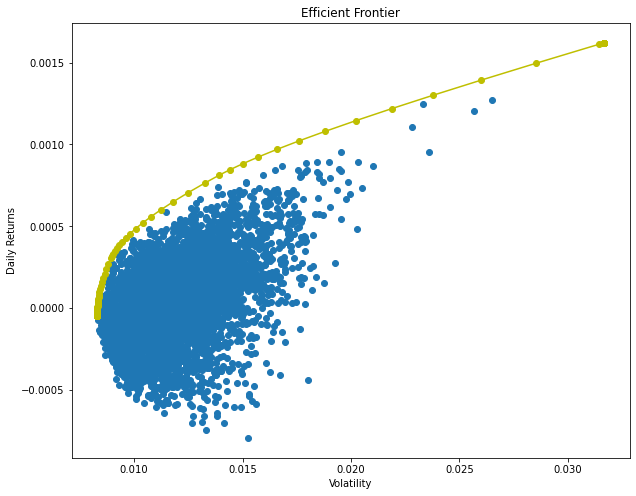

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize =(10,8))
plt.scatter(data = portfolio_options, x = 'Volatility', y = "Returns")
plt.xlabel('Volatility')
plt.ylabel('Daily Returns')
plt.title('Efficient Frontier')
plt.plot(risks, returns, 'y-o')
plt.show()
plt.clf()


### Quick Analysis

Can see that a lot of the portfolios actually have a negative daily return (due to `WDC`, `IVZ`, and `PPL` having a bad sell off during this time), so say we want to just pick some portfolios that have a positive return, and a medium volatility level. Lets randomly pick a range for the daily returns (positive of course since no one wants to lose money), and a positive range for vol thats not greater than 0.3 (since no one wants a super volatile portfolio)

In [22]:
#lets pick vol range of 0.15 -> 0.21
#lets pick return range of 0.0007 -> 0.0012

returns_range = np.array([0.0007, 0.0012])
volatility_range = np.array([0.15, 0.21])

lower_vol_portfolio = portfolio_options[(portfolio_options.Returns > returns_range[0]) & (portfolio_options.Volatility < volatility_range[0])]
higher_returns_portfolio = portfolio_options[(portfolio_options.Returns > returns_range[1]) & (portfolio_options.Volatility < volatility_range[1])]


### Analysis

So what we've done here is picked two portfolios: one portfolio that is taking lower volatility (and in turn giving you lower returns), and one portfolio that is taking higher volatility (and giving you higher returns).

So lets just put the portfolios next to each other (look below):


In [23]:
lower_vol_portfolio[lower_vol_portfolio.Volatility == lower_vol_portfolio.Volatility.min()]

,Returns,Volatility,BLL Weight,WDC Weight,IVZ Weight,PPL Weight,TWTR Weight
3539,0.000742,0.013861,0.461171,0.016887,0.01804,0.142447,0.361455


In [24]:
higher_returns_portfolio[higher_returns_portfolio.Returns == higher_returns_portfolio.Returns.max()]

,Returns,Volatility,BLL Weight,WDC Weight,IVZ Weight,PPL Weight,TWTR Weight
839,0.001273,0.026514,0.034809,0.033479,0.050463,0.056635,0.824614


So now we've seen that the efficient portfolio with the lowest volatilty and highest return has the weights of:

- `BLL`: 0.461
- `WDC`: 0.017
- `IVZ`: 0.018
- `PPL`: 0.142
- `TWTR`: 0.361

And the efficient portfolio with the highest return for the highest volatility has the weights of:

- `BLL`: 0.035
- `WDC`: 0.033
- `IVZ`: 0.050
- `PPL`: 0.056
- `TWTR`: 0.825

This makes sense since:
- __Portfolio 1__:
    - `BLL` had the most consistent and least volatile daily returns while `TWTR` and `WDC` were easily the highest. In a portfolio targeting low volatility, we should be more heavily weighting the stock that produced consistency rather than returns (which is shown by a 46% weight to BLL versus the other 4).
- __Portfolio 2__:
    - `TWTR` had the biggest returns (accompanied with the largest volatility). This portfolio is focused on producing the highest returns with a much higher volatility so we expect to be heavily weighted to `TWTR` and not much to the other stocks (as shown in this portfolio with a 82.5% weight to `TWTR`).

### User Input Portfolio

So can now make a function where the user can input their portfolio money, input the risk they want, and we return the optimized portfolio:


In [25]:
portfolio_size = int(input("Enter the size of your portfolio: "))
vol_size = input("Enter your maximum risk amount as a number from 0.00 to 1.00: ")
stock_picks = input("Enter the 5 stocks you are thinking about investing in (ALL CAPS - SEPERATED BY A COMMA): ")

try:
    val =  float(portfolio_size)
except ValueError:
    print("That's not a number! \n Please try again and enter numbers only:")
    portfolio_size = input("Enter the value of your portfolio: ")
    val = float(portfolio_size)

Enter the size of your portfolio: 100000
Enter your maximum risk amount as a number from 0.00 to 1.00: .22
Enter the 5 stocks you are thinking about investing in (ALL CAPS - SEPERATED BY A COMMA): BLL, WDC, IVZ, PPL, TWTR


In [26]:
def inputed_portfolio(stock_picks, vol_size, portfolio_size):
    portfolio_amount = float(portfolio_size)
    vol = float(vol_size)
    start = datetime(2017, 1, 1)
    end = datetime(2019, 1, 2)
    stock_tickers = stock_picks.split(", ")
    stock1, stock2, stock3, stock4, stock5 = [i for i in stock_tickers]
    
    
    stockss = web.DataReader(stock_tickers, start=start, end=end, data_source = 'yahoo')
    adjusted_close = stockss["Adj Close"]
    stocks_change = adjusted_close.pct_change()
    stocks_daily_return = stocks_change.mean()
    stocks_daily_cov = stocks_change.cov()
    stock_port = return_portfolios(stocks_daily_return, stocks_daily_cov)
    #weights, returns, risks = optimal_portfolio(stocks_change[1:])

    returns_range = np.array([0.0000, 0.07])
    volatility_range = np.array([(vol-0.005), (vol)])

    lower_vol_portfolio = stock_port[(stock_port.Returns > returns_range[0]) & (stock_port.Volatility < volatility_range[0])]
    higher_returns_portfolio = stock_port[(stock_port.Volatility <= volatility_range[1])]

    
    x = lower_vol_portfolio[lower_vol_portfolio.Volatility == lower_vol_portfolio.Volatility.min()]
    y = higher_returns_portfolio[higher_returns_portfolio.Returns == higher_returns_portfolio.Returns.max()]
    
        
    
    elist = []
    for stock in stock_tickers:
        elist.append(stock + " Weight")
    elist2 = []
    for stock in elist:
        elist2.append(y[stock].values)
    total = []
    for weight in elist2:
        total.append(weight*portfolio_amount)
    final_prices = []
    for stock in adjusted_close:
        final_prices.append(adjusted_close[stock][-1])
    
    final_port = []
    for i in range(5):
        final_port.append(total[i]/final_prices[i])
    final_port = np.round(final_port, 2)
    
    print("The portfolio below shows the returns, volatility, and weights of each stock in order to optimize the portfolio based off daily returns.")
    
    print("""The amount of shares to buy of the stocks as of the last closing price is:
          {x1}: {y1},
          {x2}: {y2},
          {x3}: {y3},
          {x4}: {y4},
          {x5}: {y5}
          """.format(x1=stock1, y1=final_port[0], x2=stock2, y2=final_port[1], x3=stock3, y3=final_port[2], x4=stock4, y4=final_port[3], x5=stock5, y5=final_port[4]))
    return y

    

In [27]:
# Now call the function above and should get the optimal portfolio, 
# the weights of each stock, and the amount of shares to buy of each based off the portfolio size!

inputed_portfolio(stock_picks, vol_size, portfolio_size)


The portfolio below shows the returns, volatility, and weights of each stock in order to optimize the portfolio based off daily returns.
The amount of shares to buy of the stocks as of the last closing price is:
          BLL: [207.24],
          WDC: [29.05],
          IVZ: [598.99],
          PPL: [40.65],
          TWTR: [2777.42]
          


,Returns,Volatility,BLL Weight,WDC Weight,IVZ Weight,PPL Weight,TWTR Weight
3142,0.001247,0.02584,0.090944,0.010549,0.088078,0.010255,0.800174


## Summary

- Took 5 random stock from the S&P500 and ran analysis to see the simple return, the average daily return, and the correlation and variances between the stocks.
- Then created a function where a user can input his portfolio value, his risk appetite (measured as volatility), and the list of 5 tickers he wants to invest in.
    - The function then calculates the portfolio that maximizes returns for his risk appetite.
    - The function then outputs the weights for each stock in the optimized portfolio, and the amount of shares needed to buy based off the closing price of the last trading day in our date range
- Important to note that we did this analysis on the market __PRE-pandemic__. The market post pandemic is completely different. 
    - If want to see with pandemic included, simply change the end date in the function to __now__ and we will have a completely up to date portfolio